In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn


In [124]:
food = pd.read_csv('fr.openfoodfacts.org.products.csv', sep="\t", nrows=200000)

food = food.loc[food['allergens'].dropna().index]

cols = (['allergens', 'product_name']
        + [col for col in food.columns
           if (("100g" in col)
               and not ("acid" in col)
               and not ("-fat" in col)
              )
          ][:10])
len(cols)
food = food[cols].copy()

food['allergens'] = [s.lower().replace("en:", "").replace("es:", "")
                     for s in food['allergens']  if isinstance(s, str) ]

common_allergens = {
    'wheat': ("blé", "wheat", "ble", ),
    "milk": ('leche', 'lait', 'milk', 'milch'),
    "gluten": ("gluten", ),
    "nut": ("almond", "almendra", "nut", "noisettes", "amandes"),
    "soy": ("soja", "soy"),
    "egg": ('egg', 'œuf', 'oeuf', 'huevo')
}



for key, trans in common_allergens.items():
    food["has_"+key] = [np.any([t in allergens for t in trans])
                 for allergens in food['allergens']]


food = food.dropna(axis=1, how="all").fillna(0.0)
food = food.drop(columns=["energy_100g", "cholesterol_100g", "lactose_100g"])


data_cols = [col for col in food.columns if "100g" in col]
allergy_cols = [col for col in food.columns if "has_" in col]
food.shape



/home/guillaume/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3497, 11)

In [125]:
food["total_alergies"] = food[allergy_cols].sum(axis=1)

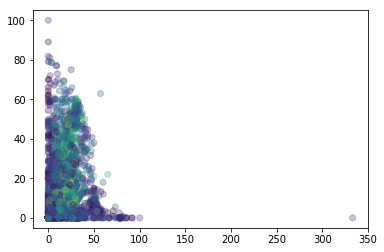

In [126]:
fig, ax = plt.subplots()

ax.scatter(food.fat_100g, food.sugars_100g,
           c=food.total_alergies, alpha=0.3)

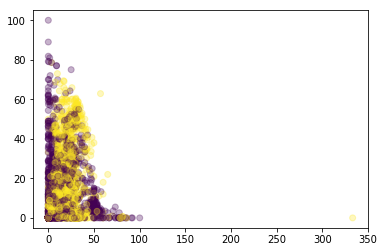

In [111]:
fig, ax = plt.subplots()

ax.scatter(food.fat_100g, 
           food.sugars_100g,
           c=food.has_milk, alpha=0.3)

In [128]:
food["total_alergies"].max()

6

In [154]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



X = food[data_cols].clip(0, 100)
y = food["total_alergies"]

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)


X_pca = pca.fit_transform(X)
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))



explained variance ratio (first two components): [0.69129903 0.20682097]


In [149]:
food["has_milk"].sum() / food.shape[0]

0.4792679439519588

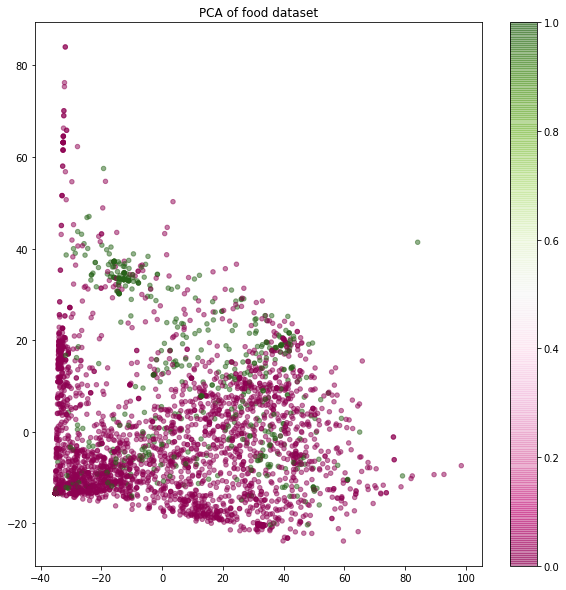

In [201]:

fig, ax = plt.subplots()
sc = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=food["has_nut"],
    alpha=.5, s=20, cmap='PiYG'
)
fig.colorbar(sc)

ax.set_title('PCA of food dataset')
fig.set_size_inches(10, 10);



In [178]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=10).fit(X_pca)
kmeans.labels_




array([1, 1, 2, ..., 2, 2, 2], dtype=int32)

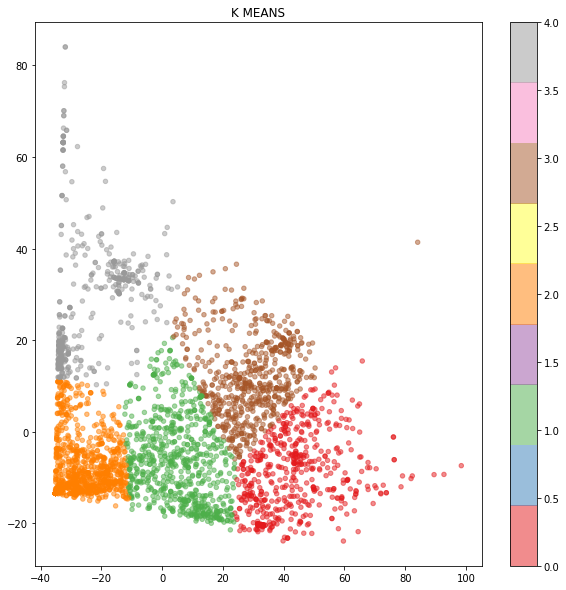

In [179]:
fig, ax = plt.subplots()
sc = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans.labels_,
    alpha=.5, s=20, cmap='Set1'
)
fig.colorbar(sc)

ax.set_title('K MEANS')
fig.set_size_inches(10, 10);


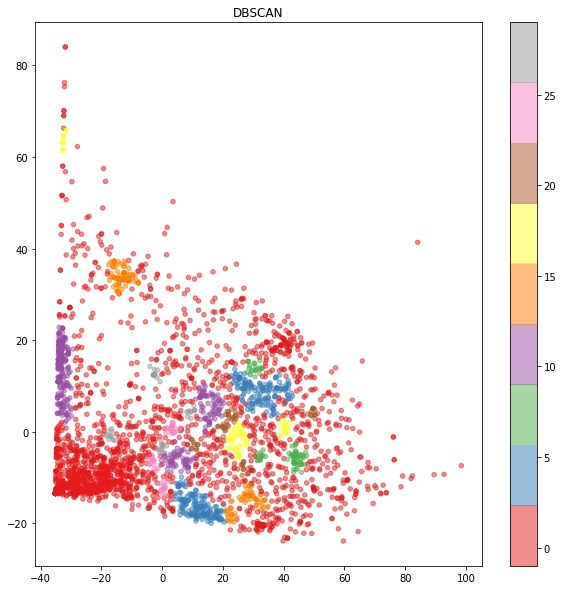

In [206]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1.7, min_samples=10).fit(X_pca)

fig, ax = plt.subplots()
sc = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=clustering.labels_,
    alpha=.5, s=20, cmap='Set1'
)
fig.colorbar(sc)

ax.set_title('DBSCAN')
fig.set_size_inches(10, 10);

In [198]:
food[clustering.labels_==7].shape

(118, 12)

Automatically created module for IPython interactive environment


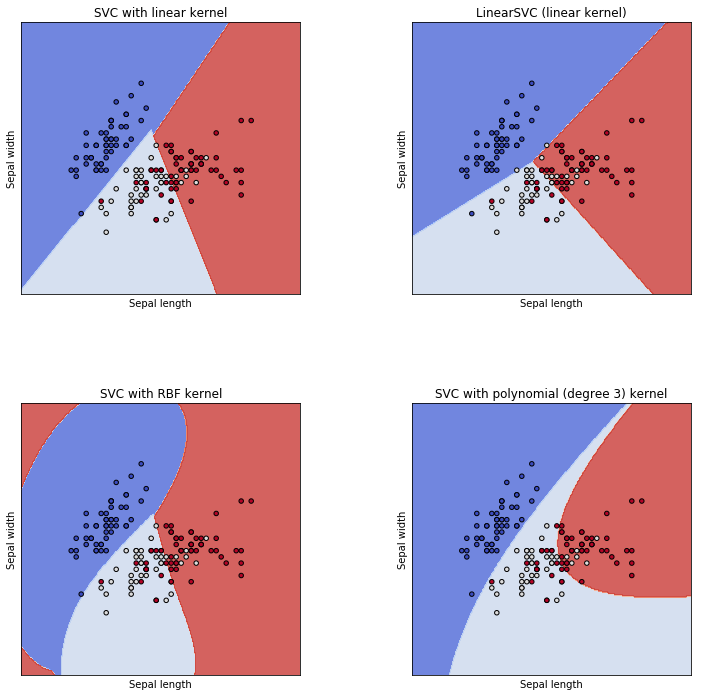

In [205]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

fig.set_size_inches(12, 12)